In [287]:
import itertools as it

import networkx as nx
import numpy as np
from scipy import sparse

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

import matplotlib.pyplot as plt


In [249]:
# utils 

def read_sat(sat_path):
    with open(sat_path) as f:
        sat_lines = f.readlines()
        header = sat_lines[0]
        header_info = header.replace("\n", "").split(" ")
        num_vars = int(header_info[-2])
        num_clauses = int(header_info[-1])

        sat = [[int(x) for x in line.replace(' 0\n', '').split(' ')]
               for line in sat_lines[1:]]

        return sat, num_vars, num_clauses


def sat_to_lig_adjacency_matrix(sat, num_vars):
    get_literal_idx = lambda x: 2 * x - 2 if x > 0 else 2 * abs(x) - 1
    lig_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    lig_weighted_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])

    for clause in sat:
        pairs = it.combinations(clause, 2)
#         print(f'clause: {clause}')
        for pair in pairs:
            x_idx = get_literal_idx(pair[0])
            y_idx = get_literal_idx(pair[1])
#             print(f'pair: {(x_idx, y_idx)}')
            lig_adjacency_matrix[x_idx, y_idx] = 1
            lig_adjacency_matrix[y_idx, x_idx] = 1
            lig_weighted_adjacency_matrix[x_idx, y_idx] += 1
            lig_weighted_adjacency_matrix[y_idx, x_idx] += 1    
    return lig_adjacency_matrix, lig_weighted_adjacency_matrix

In [267]:
class GCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        # GCN initialization
        self.conv1 = GCNConv(node_features, 64)
        self.conv2 = GCNConv(64, 128)
        # self.conv1 = GATConv(node_features, 64, 5)
        # self.conv2 = GATConv(64 * 5, 128)

        # self.conv3 = GCNConv(128, 128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.elu(x)
        # x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        # x = F.tanh(x)
        # x = self.conv3(x, edge_index)
        
        # x1^T * W * x2

        return x


(array([  0,   0,   0, ..., 181, 181, 181]), array([  2,   4,  14, ..., 135, 169, 178]))
tensor([[  0,   0,   0,  ..., 181, 181, 181],
        [  2,   4,  14,  ..., 135, 169, 178]])
[6. 6. 1. ... 2. 1. 3.]
histogram of original weight: (array([1516,  440,   80,   60,   14,   14]), array([1, 2, 3, 4, 5, 6, 7]))


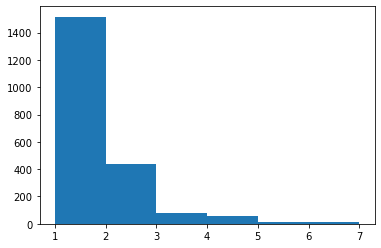

[6. 6. 1. ... 2. 1. 3.]


In [288]:
sat_path = './ssa2670-141.processed.cnf'
sat_instance, num_vars, num_clauses = read_sat(sat_path)

lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
print(lig_adjacency_matrix.nonzero())


# graph = nx.from_numpy_matrix(lig_adjacency_matrix)
# edges = nx.to_edgelist(graph)
# print(lig_adjacency_matrix.nonzero())

edge_index = torch.tensor(lig_adjacency_matrix.nonzero(), dtype=torch.long)
print(edge_index)
edge_value = lig_weighted_adjacency_matrix[lig_adjacency_matrix.nonzero()]
print(edge_value)
print(f'histogram of original weight: {np.histogram(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])}')
plt.hist(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])
plt.show()
# max_edge_value = max(edge_value)
# norm_edge_value = edge_value/max_edge_value
norm_edge_value = edge_value
print(norm_edge_value)

embeddings = torch.load('./embeddings.pt')
embeddings.requires_grad = False
# print(embeddings)
x = embeddings
data = Data(x=x, edge_index=edge_index)


In [269]:
# training
model = GCN(50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    src, dst = edge_index
    score = (out[src] * out[dst]).sum(dim=-1)
    # score = torch.sigmoid(score)
    loss = F.mse_loss(score, torch.tensor(norm_edge_value, dtype=torch.float))
    loss.backward()
    optimizer.step()
    print(f'epoch: {epoch}, loss: {loss.item()}')


# TBD
# 1. product sum 
#

epoch: 0, loss: 1.1641110181808472
epoch: 1, loss: 1.4175746440887451
epoch: 2, loss: 0.7755216956138611
epoch: 3, loss: 2.072573184967041
epoch: 4, loss: 0.7336053252220154
epoch: 5, loss: 0.8084513545036316
epoch: 6, loss: 1.0635331869125366
epoch: 7, loss: 1.1253913640975952
epoch: 8, loss: 1.0059610605239868
epoch: 9, loss: 0.7969239950180054
epoch: 10, loss: 0.686897873878479
epoch: 11, loss: 0.8059244751930237
epoch: 12, loss: 0.8264654874801636
epoch: 13, loss: 0.6877186298370361
epoch: 14, loss: 0.609920859336853
epoch: 15, loss: 0.629022479057312
epoch: 16, loss: 0.6754872798919678
epoch: 17, loss: 0.6977923512458801
epoch: 18, loss: 0.6801174879074097
epoch: 19, loss: 0.6346316933631897
epoch: 20, loss: 0.5933061242103577
epoch: 21, loss: 0.5881275534629822
epoch: 22, loss: 0.6123658418655396
epoch: 23, loss: 0.6167895197868347
epoch: 24, loss: 0.5849300026893616
epoch: 25, loss: 0.5537311434745789
epoch: 26, loss: 0.5475904941558838
epoch: 27, loss: 0.5561403036117554
epoch:

In [270]:
out = model(data)
src, dst = edge_index
score = (out[src] * out[dst]).sum(dim=-1)
# print(min(score))
# score = torch.sigmoid(score)
print(f"norm_edge_value: {norm_edge_value}")
print(f"score: {score.detach()}")
print(f"min score: {min(score)}")
print(f"max score: {max(score)}")

norm_edge_value: [6. 6. 1. ... 2. 1. 3.]
score: tensor([4.8779, 6.0709, 0.7641,  ..., 2.1305, 2.0319, 3.2457])
min score: 0.3705979585647583
max score: 6.070923328399658


In [271]:
lig_adjacency_matrix
sparse_matrix = sparse.csr_matrix(lig_adjacency_matrix)
sparse_matrix

<182x182 sparse matrix of type '<class 'numpy.float64'>'
	with 2124 stored elements in Compressed Sparse Row format>

In [261]:
# CELL
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz

import torch

from cell.utils import link_prediction_performance
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics

cell_model = Cell(A=sparse_matrix,
             H=9,
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])


cell_model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})


Step:  10/200 Loss: 3.92775 Edge-Overlap: 0.388 Total-Time: 0
Step:  20/200 Loss: 3.35798 Edge-Overlap: 0.570 Total-Time: 0


In [262]:
generated_graph = cell_model.sample_graph()
print(generated_graph.A)
print(generated_graph.A.nonzero())
# compute_graph_statistics(generated_graph)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(array([  0,   0,   0, ..., 181, 181, 181]), array([  2,  14,  15, ..., 134, 135, 149]))


In [293]:
graph_prime = generated_graph.A
edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
print(edge_index_prime.size())
data_prime = Data(x=x, edge_index = edge_index_prime)
out = model(data_prime)
print(out)
src, dst = edge_index_prime
score = (out[src] * out[dst]).sum(dim=-1)
print(score)
print(len(score))
weight = score.detach().numpy()
weight[weight <= 1] = 1
weight = np.rint(weight).astype(int)
print(f'histogram of inference weight: {np.histogram(weight, bins=[1, 2, 3, 4, 5, 6, 7])}')
# plt.hist(weight, bins=[1, 2, 3, 4, 5, 6, 7])

torch.Size([2, 2124])
tensor([[ 0.1458, -0.0650, -0.2092,  ...,  0.3151,  0.2128, -0.0984],
        [-0.0693, -0.1420, -0.3167,  ...,  0.2207,  0.0885, -0.0737],
        [ 0.0043, -0.1312, -0.1235,  ...,  0.1458,  0.1412, -0.0531],
        ...,
        [-0.1151,  0.0292,  0.0620,  ..., -0.1073, -0.0698, -0.0251],
        [-0.1774,  0.0396,  0.1497,  ..., -0.3238, -0.2087,  0.0173],
        [-0.1513,  0.0180,  0.2388,  ...,  0.1160,  0.1926, -0.0532]],
       grad_fn=<AddBackward0>)
tensor([ 2.4964,  0.8891, -0.7602,  ...,  2.4207,  3.3430,  0.5872],
       grad_fn=<SumBackward1>)
2124
histogram of inference weight: (array([1604,  424,   84,    6,    6,    0]), array([1, 2, 3, 4, 5, 6, 7]))
